<a href="https://colab.research.google.com/github/ASEM000/Physics-informed-neural-network-in-JAX/blob/main/%5B3%5D_PDE_Laplace_PINN_ClassForm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Credits : Mahmoud Asem @Asem000  July 2021

In [2]:
!pip install optax
!pip install pytreeclass # for PyTorch like API
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#Imports
from typing import List , Callable
import jax 
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl

import optax
from pytreeclass import treeclass,tree_viz
import sympy as sp
import functools
from tqdm.notebook import tqdm

In [4]:
def plot2D(T,X, p):
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(T, X, p[:],  cmap=cm.viridis)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.view_init(30,225)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

#### Laplace
$\frac{\partial ^2 p}{\partial x^2} + \frac{\partial ^2 p}{\partial y^2} = 0$ 

<br>
$\text{p = 0 at x=0}$ <br>
$\text{p = y at x=2}$ <br>
$\frac{\partial p}{\partial y} = 0 \ at \ y=0,1$



In [5]:
N_b = 100
N_r = 10_000

ymin,ymax=0. ,1.
xmin,xmax = 0.,2.

'''boundary conditions'''

bk1,bk2,bk3,bk4,r1k,r2k = jax.random.split(jax.random.PRNGKey(0),6)



# P[0,y] = 0
y_b1 = jax.random.uniform(bk1,minval=ymin,maxval=ymax,shape=(N_b,1))
x_b1 = jnp.zeros_like(y_b1)
bc_1 = jnp.zeros_like(y_b1)
BC_1 = jnp.concatenate([x_b1,y_b1,bc_1],axis=1)

# P[2,y] = y
y_b2 = jax.random.uniform(bk2,minval=ymin,maxval=ymax,shape=(N_b,1))
x_b2 = jnp.ones_like(y_b2) *2
bc_2 = y_b2
BC_2 = jnp.concatenate([x_b2,y_b2,bc_2],axis=1)

# P_y[x,0] = 0
x_b3 = jax.random.uniform(bk3,minval=xmin,maxval=xmax,shape=(N_b,1))
y_b3 = jnp.zeros_like(x_b3)
bc_3 = jnp.zeros_like(x_b3)
BC_3 = jnp.concatenate([x_b3,y_b3,bc_3],axis=1)

# P_y[x,1] = 0
x_b4 = jax.random.uniform(bk4,minval=xmin,maxval=xmax,shape=(N_b,1))
y_b4 = jnp.ones_like(x_b4)
bc_4 = jnp.zeros_like(x_b4)
BC_4 = jnp.concatenate([x_b4,y_b4,bc_4],axis=1)

conds = [BC_1,BC_2,BC_3,BC_4]

#collocation points
y_c = jax.random.uniform(r1k,minval=ymin,maxval=ymax,shape=(N_r,1))
x_c = jax.random.uniform(r2k,minval=xmin,maxval=xmax,shape=(N_r,1))
colloc = jnp.concatenate([x_c,y_c],axis=1) 

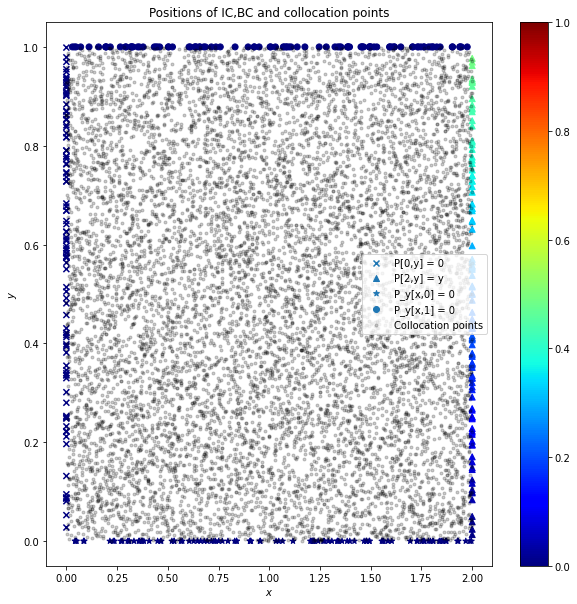

In [6]:
fig = plt.figure(figsize=(10,10))
plt.scatter(x_b1, y_b1, c=bc_1, marker='x', vmin=0, vmax=2,label='P[0,y] = 0',cmap=cm.jet)
plt.scatter(x_b2, y_b2, c=bc_2, marker='^', vmin=0, vmax=2,label='P[2,y] = y',cmap=cm.jet)
plt.scatter(x_b3, y_b3, c=bc_3, marker='*', vmin=0, vmax=2,label='P_y[x,0] = 0',cmap=cm.jet)
plt.scatter(x_b4, y_b4, c=bc_4, marker='o', vmin=0, vmax=2,label='P_y[x,1] = 0',cmap=cm.jet)


cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=0, vmax=1)


plt.scatter(x_c, y_c, c='k', marker='.', alpha=0.2,label='Collocation points',cmap=cm.jet)
plt.xlabel('$x$')
plt.ylabel('$y$')

plt.title('Positions of IC,BC and collocation points');
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap))
plt.legend(loc='center right')

In [7]:
from __future__ import annotations 
from typing import Any 

@treeclass
class Linear :
    weight : jnp.ndarray
    bias   : jnp.ndarray

    def __init__(self,key,in_dim,out_dim):

        lb, ub = -(1 / jnp.sqrt(in_dim)), (1 / jnp.sqrt(in_dim)) # xavier initialization lower and upper bound
        self.weight = lb + (ub-lb) * jax.random.uniform(key,shape=(in_dim,out_dim))
        self.bias = jax.random.uniform(key,shape=(out_dim,))

    def __call__(self,x):
        return x @ self.weight + self.bias
        
@treeclass 
class MLP:
    layers : list[Linear]

    def __init__(self,layers:list[int],key=jax.random.PRNGKey(0)):
        
        keys = jax.random.split(key,len(layers))
        self.layers = []

        for i,(key,in_dim,out_dim) in enumerate(zip(keys,layers[:-1],layers[1:])):
            self.layers += [Linear(key,in_dim,out_dim)]

    def __call__(self,x):
        *hidden,last = self.layers 

        for layer in hidden:
            x = layer(x)
            x = jax.nn.tanh(x)
        return last(x)

def diff(func:Callable,argnum=0):
    """sum then grad"""
    return jax.grad(lambda *ar,**kw : jnp.sum(func(*ar,**kw)),argnum)
    
def PDE_loss(x,y,u):
    u_x= diff(u,0)
    u_xx= diff(u_x,0)
    u_y= diff(u,1)
    u_yy= diff(u_y,1)
    return u_xx(x,y) + u_yy(x,y)

def MSE(true,pred):
    return jnp.mean((true-pred)**2)


def loss_func(model,colloc,conds):
    x_c,y_c =colloc[:,[0]],colloc[:,[1]]
    ufunc = lambda x,y : model(jnp.concatenate([x,y],axis=-1))
    ufunc_y = diff(ufunc,1)
  
    loss =jnp.mean(PDE_loss(x_c,y_c,ufunc) **2)
        
    for cond in conds[0:2] :
        x_b,y_b,u_b = cond[:,[0]],cond[:,[1]],cond[:,[2]]  
        loss += MSE(ufunc(x_b,y_b),u_b)
  
    for cond in conds[2:4] :
        x_b,y_b,u_b = cond[:,[0]],cond[:,[1]],cond[:,[2]]  
        loss += MSE(ufunc_y(x_b,y_b),u_b)

    return  loss

@jax.jit
def update(opt_state,model,colloc,conds):
    # Get the gradient w.r.t to MLP 
    grads=jax.grad(loss_func,0)(model,colloc,conds)

    #Update model
    updates, opt_state = optimizer.update(grads, opt_state)
    model = optax.apply_updates(model, updates)

    return opt_state,model

model = MLP(layers=[2]+[8]*4 + [1])
optimizer = optax.adam(5e-3)
opt_state = optimizer.init(model)

epochs = 10_000
for _ in tqdm(range(1,epochs+1)):
    opt_state,model = update(opt_state,model,colloc,conds)

    # print loss and epoch info
    if _ %(1000) ==0:
        print(f'Epoch={_}\tloss={loss_func(model,colloc,conds):.3e}')

print(f'Epoch={_}\tloss={loss_func(model,colloc,conds):.3e}')

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch=1000	loss=1.954e-03
Epoch=2000	loss=1.331e-03
Epoch=3000	loss=1.236e-03
Epoch=4000	loss=1.148e-03
Epoch=5000	loss=1.118e-03
Epoch=6000	loss=1.110e-03
Epoch=7000	loss=1.068e-03
Epoch=8000	loss=1.049e-03
Epoch=9000	loss=1.021e-03
Epoch=10000	loss=9.819e-04
Epoch=10000	loss=9.819e-04


### Numerical solution

In [8]:
from matplotlib import cm 
import matplotlib.pyplot as plt
import numpy as np
# import numba
##variable declarations
nx = 101
ny = 101
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)

##initial conditions
p = np.zeros((ny, nx))  # create a XxY vector of 0's

##plotting aids
x = np.linspace(0, 2, nx)
y = np.linspace(0, 1, ny)

##boundary conditions
p[:, 0] = 0  # p = 0 @ x = 0
p[:, -1] = y  # p = y @ x = 2
p[0, :] = p[1, :]  # dp/dy = 0 @ y = 0
p[-1, :] = p[-2, :]  # dp/dy = 0 @ y = 1


def laplace_step(p, y, dx, dy):
    pn = p.copy()
    p[1:-1, 1:-1] = ((dy**2 * (pn[1:-1, 2:] + pn[1:-1, 0:-2]) + dx**2 * (pn[2:, 1:-1] + pn[0:-2, 1:-1])) / (2 * (dx**2 + dy**2)))
    
    #Boundary condition
    p[:, 0] = 0                 # p[y,0] = 0                   p = 0 @ x = 0
    p[:, -1] = y                # p[y,2] = y                   p = y @ x = 2
    p[0, :] = p[1, :]           # p_y[0,x] = 0                 dp/dy = 0 @ y = 0
    p[-1, :] = p[-2, :]         # p_y[1,x] = 0                 dp/dy = 0 @ y = 1

    norm = (np.sum(np.abs(p[:]) -np.abs(pn[:])) /np.sum(np.abs(pn[:])))
     
    return p,norm

norm = 1
step = 0
while norm> 1e-4:
  p,norm = laplace_step(p,y,dx,dy)
  step+=1
  if step %1000 == 0:
    print(f'step={step}\tl1norm={norm:.3e}')



step=1000	l1norm=4.863e-04
step=2000	l1norm=2.421e-04
step=3000	l1norm=1.535e-04
step=4000	l1norm=1.053e-04


### Numerical solution

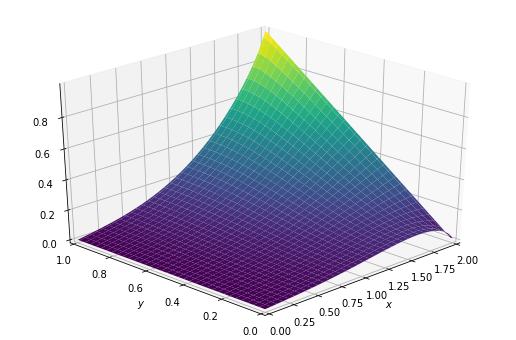

In [9]:
#numerical solution
N = 100
X,Y = np.meshgrid(x, y)
pred = model(jnp.concatenate([X.flatten().reshape(-1,1),Y.flatten().reshape(-1,1)],axis=-1)).reshape(N+1,N+1)
plot2D(X,Y,p)

### PINN solution

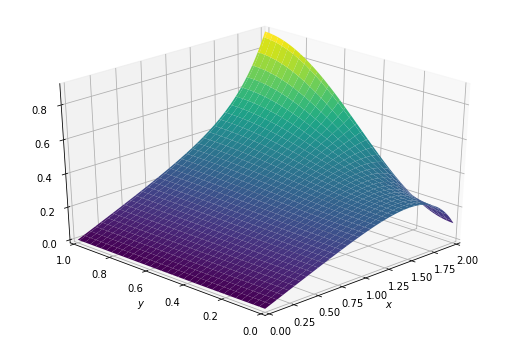

In [10]:
# prediction
plot2D(X,Y,pred)